# MIT iQuHack 2025: Alice and Bob Challenge
## Noisy but Nice (Adam Godel, Jacky Lin, Felix Bagurskas Rubio, Ege Topkoc, Temi Kayas)
### Introduction
This Jupyter notebook contains our group's solutions for the MIT iQuHack 2025 Alice and Bob challenge. As students with a primarily math and computer science background, we found the Alice and Bob challenge to be very different than anything we have done before, and we learned a significant amount about cat qubits and QED. We were able to code solutions for all of the tasks, and we are very proud of the work we were able to achieve, despite having some computational issues when trying to execute some of the later tasks.

In [3]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import optax
import jax

## Task 1: Simulate the dynamics of cat qubits at the effective Hamiltonian level.
This task concerns the Lindblad master equation
$$
\frac{d\hat{\rho}}{dt} = L[\hat{\rho}] = -i[\hat{H}, \hat{\rho}] + \kappa_b D(\hat{b})[\hat{\rho}]
$$
The Hamiltonian of the system is given by
$$
\begin{align*}
\hat{H} &= \hat{H}_{2ph} + \hat{H}_d, \text{ with} \\
\hat{H}_{2ph} &= g_2 \hat{a}^{\dag^2} \hat{b} + g_2^{*} \hat{a}^2 \hat{b}^\dag, \\
\hat{H}_d &= \epsilon_d^{*} \hat{b} + \epsilon_d \hat{b}^\dag,
\end{align*}
$$
where $\hat{H}_{2ph}$ is the two-photon exchange Hamiltonian and $\hat{H}_d$ is the buffer drive Hamiltonian.
### Task 1.1: Getting started with `dynamiqs`
To begin, we are given a few unitless parameters:
$$
g_2 = 1.0, \epsilon_d = -4, \kappa_b = 10,
$$
with an initial vacuum state $|\phi_0\rangle$ (a Fock state of zero in both the $a$ and $b$ modes) and a Hilbert space truncation $n_a = 20$ and $n_b = 5$. We simulate for time $T = 4$.

This task is as simple as plugging in the given values as parameters for our simulation. We create $\hat{a}$ and $\hat{b}$ as bosonic annihilation operators based on the given dimensions $n_a$ and $n_b$, and write out the definitions of $H_{2ph}$ and $H_d$ in Python, summing them to get our Hamiltonian $H$. We use the loss operator $\sqrt{\kappa_b} b$, corresponding to the equation above. We then simulate from $T=0$ to $T=4$, taking 100 steps in between, to get the following Wigner function:

|██████████| 100.0% ◆ elapsed 307.11ms ◆ remaining 0.00ms  
100%|██████████| 50/50 [00:01<00:00, 28.04it/s]


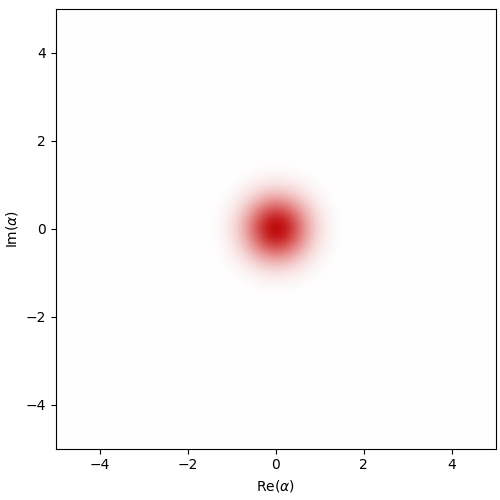

In [4]:
(na, nb) = (20, 5)
a, b = dq.destroy(na, nb)
adag, bdag = a.dag(), b.dag()
psi0 = dq.fock((na, nb), (0, 0))

kappa_b = 10
epsilon_d = -4
g2 = 1.0

H2ph = g2 * (adag @ adag) @ b + jnp.conj(g2) * (a @ a) @ bdag
Hd = jnp.conj(epsilon_d) * b + epsilon_d * bdag
H = H2ph + Hd

tsave = jnp.linspace(0, 4, 100)
res = dq.mesolve(H, [jnp.sqrt(kappa_b) * b], psi0, tsave)
rho = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho)

We are also asked to calculate the expected value of the number of photons, $N = a^\dag a$, which we can do using the `expect` and `number` functions provided by `dynamiqs`. We then simply plot using `matplotlib`:

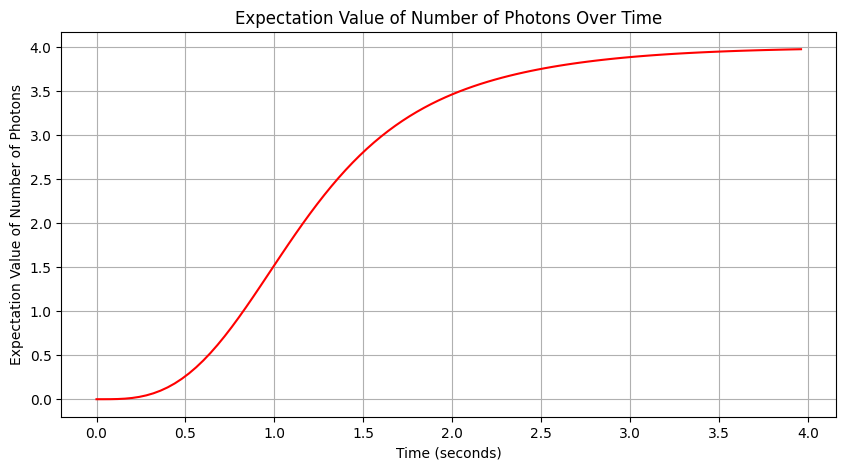

In [9]:
exp_n = dq.expect(dq.number(na), rho)

# x axis is time with 4/100 second intervals
# y axis is going expectation value of number of photons (exp_n) at each point

# Define the time axis with 4/100 second intervals
time = np.arange(len(exp_n)) * (4 / 100)  # 4/100 seconds per interval
# Creating the plot with proper labels
plt.figure(figsize=(10, 5))
plt.plot(time, exp_n.real, marker='', linestyle='-', color='r')
plt.title("Expectation Value of Number of Photons Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Expectation Value of Number of Photons")
plt.grid(True)

# Show the plot
plt.show()


We can see that the expected value of the number of photons appears to converge to 4.

We are also asked to calculate the photon number parity in the memory mode. We can do so using the `expect` and `parity` functions provided by `dynamiqs`, very similarly to above:

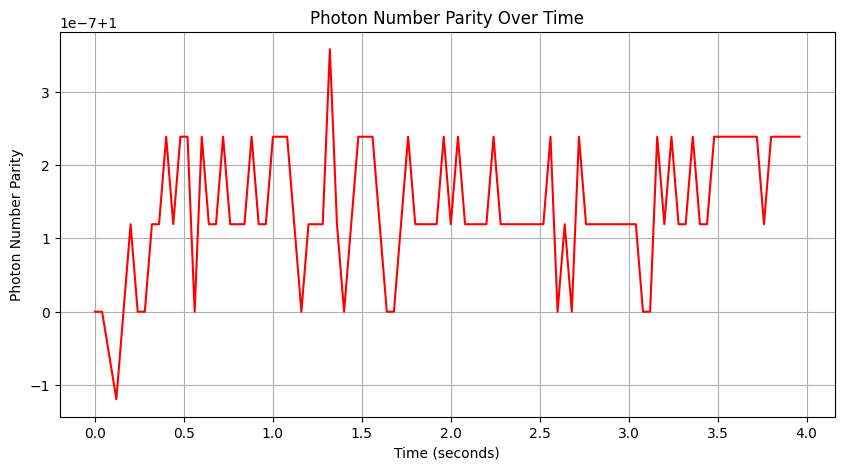

In [70]:
par_n = dq.expect(dq.parity(na), rho)

# x axis is time with 4/100 second intervals
# y axis is photon number parity (par_n) at each point

# Define the time axis with 4/100 second intervals
time = np.arange(len(par_n)) * (4 / 100)  # 4/100 seconds per interval
# Creating the plot with proper labels
plt.figure(figsize=(10, 5))
plt.plot(time, par_n.real, marker='', linestyle='-', color='r')
plt.title("Photon Number Parity Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Photon Number Parity")
plt.grid(True)

# Show the plot
plt.show()

We can see that the fluctuations are simply numerical noise, and the parity remains at 1 for the duration of the simulation.
### Task 1.2: Comparison with eliminated buffer mode
This task asks us to consider the system where the buffer mode is adiabatically eliminated, modeled by the equation
$$
\frac{d\hat{\rho}_a}{dt} = \kappa_2 D[\hat{a}^2 - \alpha^2](\hat{\rho}_a),
$$
with two-photon dissipation rate $\kappa_2 = 4|g_2|^2/\kappa_b$ and cat amplitude $\alpha^2 = -\epsilon_d / g_2^{*}$. 

We can model this state similarly to Task 1.1, but with a loss operator of $\sqrt{\kappa_2} (\hat{a}^2 - \alpha^2)$, matching the equation above:

|██████████| 100.0% ◆ elapsed 386.77ms ◆ remaining 0.00ms  
100%|██████████| 50/50 [00:02<00:00, 22.70it/s]


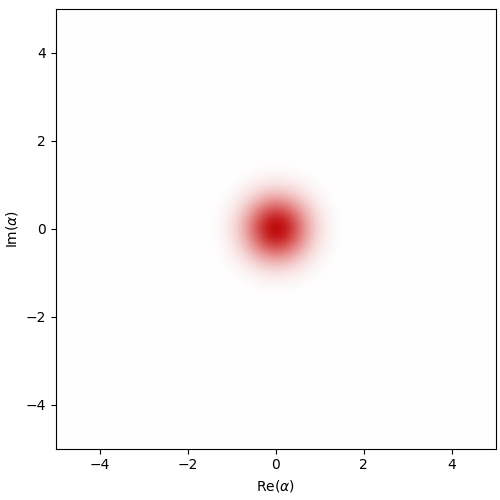

In [7]:
kappa_2 = 4 * abs(g2)**2 / kappa_b
alpha_sq = -epsilon_d / jnp.conj(g2)
tsave = jnp.linspace(0, 4, 100)

res = dq.mesolve(H, [jnp.sqrt(kappa_2) * (a @ a - alpha_sq * dq.eye(*a.dims))], psi0, tsave)
rhoa = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rhoa)

We can see that this results in the cat states forming more quickly and with more of a "bounce".

If we try lowering $\kappa_b$ to 2 instead of 10, we see that the cat states form more quickly with less of a "bounce":

|██████████| 100.0% ◆ elapsed 1.37s ◆ remaining 0.00ms     
100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


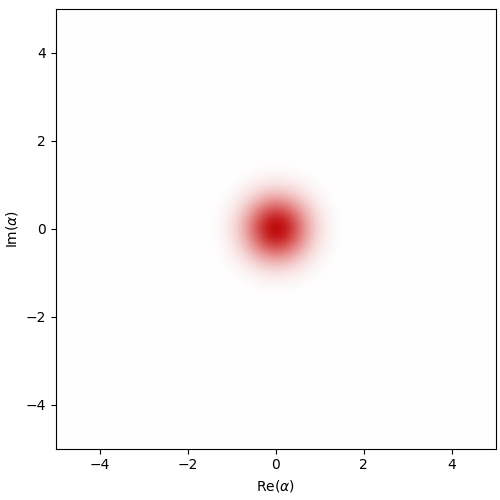

In [8]:
kappa_b = 2
kappa_2 = 4 * abs(g2)**2 / kappa_b
alpha_sq = -epsilon_d / jnp.conj(g2)

res = dq.mesolve(H, [jnp.sqrt(kappa_2) * (a @ a - alpha_sq * dq.eye(*a.dims))], psi0, tsave)
dq.plot.wigner_gif(dq.ptrace(res.states, 0))

### Task 1.3: Performing a Zeno-gate
This task asks us to add a Zeno gate operator $\hat{H}_Z = \epsilon_Z^{*} \hat{o} + \epsilon_Z \hat{o}^\dag$, where $\hat{o} = \hat{a}$ is a bosonic operator. Unlike our simulations in Tasks 1.1 and 1.2, we want to begin in the $|+\rangle$ state this time, so we set $|\psi_0\rangle = |+\rangle_a \otimes |0\rangle_b$. In this case, the plus state is defined as 
$$
|+\rangle_\alpha \equiv \mathcal{N}_+(|\alpha\rangle + |-\alpha\rangle)
$$
in accordance with the coherent state $|\alpha\rangle$, which we arbitrarily initialize to 2 in this example. We set $\epsilon_z$ to be 0.25 to avoid stretching in the $|0\rangle$ and $|1\rangle$ states in the Wigner function, although we will explore this in more detail later. By adding $H_Z$ to our previous Hamiltonian, we model a flip along the $Z$-axis:

|██████████| 100.0% ◆ elapsed 471.78ms ◆ remaining 0.00ms  
100%|██████████| 50/50 [00:02<00:00, 23.77it/s]


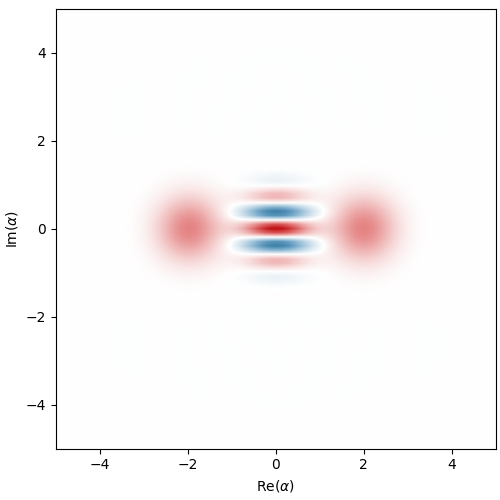

In [98]:
alpha = 2
o = a
odag = o.dag()
plus = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))
psi0 = dq.tensor(plus, dq.fock(nb, 0))

epsilon_z = 0.25

H2ph = g2 * (adag @ adag) @ b + jnp.conj(g2) * (a @ a) @ bdag
Hd = jnp.conj(epsilon_d) * b + epsilon_d * bdag
Hz = jnp.conj(epsilon_z) * o + epsilon_z * odag
H = H2ph + Hd + Hz

tsave = jnp.linspace(0, 8, 100)
res = dq.mesolve(H, [jnp.sqrt(kappa_b) * b], psi0, tsave)
rho = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho)

We can see that the Wigner function cycles between the $|+\rangle$ and $|-\rangle$ states, which are also the even and odd cat states respectively.

We are also asked to model losses of single photons in the memory mode through $\kappa_a$, the single-photon loss rate of mode $a$. We can accomplish this by initializing $\kappa_a$ to some arbitrary value, like 0.1, and passing in a second loss operator $\sqrt{\kappa_a} a$ to the simulation function:

|██████████| 100.0% ◆ elapsed 806.25ms ◆ remaining 0.00ms  
100%|██████████| 50/50 [00:02<00:00, 18.47it/s]


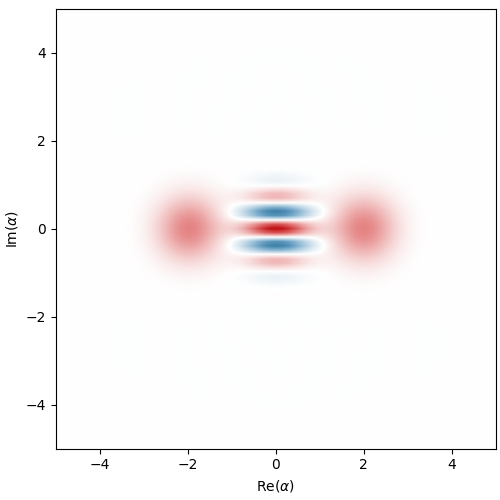

In [5]:
alpha = 2
o = a
odag = o.dag()
plus = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))
psi0 = dq.tensor(plus, dq.fock(nb, 0))

epsilon_z = 0.25
kappa_a = 0.1

H2ph = g2 * (adag @ adag) @ b + jnp.conj(g2) * (a @ a) @ bdag
Hd = jnp.conj(epsilon_d) * b + epsilon_d * bdag
Hz = jnp.conj(epsilon_z) * o + epsilon_z * odag
H = H2ph + Hd + Hz

tsave = jnp.linspace(0, 8, 100)
res = dq.mesolve(H, [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_b) * b], psi0, tsave)
rho = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho)

We can see that the cycling occurs similarly to above, but the quantum state now exhibits decoherence and fades away until only the $|0\rangle$ and $|1\rangle$ states remain.

We chose arbitrary values for $\epsilon_z$ and $\kappa_a$, so let's more systemically examine how they affect the expected photon number parity. We define a function `z_flip` that takes in values of both $\epsilon_z$ and $\kappa_a$ and returns the expected photon number parity of the simulated system with the Zeno gate:

In [100]:
def z_flip(epsilon_z, kappa_a):
    alpha = 2
    o = a
    odag = o.dag()
    plus = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))
    psi0 = dq.tensor(plus, dq.fock(nb, 0))

    H2ph = g2 * (adag @ adag) @ b + jnp.conj(g2) * (a @ a) @ bdag
    Hd = jnp.conj(epsilon_d) * b + epsilon_d * bdag
    Hz = jnp.conj(epsilon_z) * o + epsilon_z * odag
    H = H2ph + Hd + Hz

    tsave = jnp.linspace(0, 8, 100)
    res = dq.mesolve(H, [jnp.sqrt(kappa_a) * a + jnp.sqrt(kappa_b) * b], psi0, tsave)
    rho = dq.ptrace(res.states, 0)
    return dq.expect(dq.parity(na), rho)

We begin by fixing $\kappa_a$ to be 0.1 and plotting the photon number parity for different values of $\epsilon_z$ from 0.1 to 0.6:

/var/folders/z0/18qdb7n54gbdsc1tdlc78lgm0000gn/T/ipykernel_8423/3854928111.py:11: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  Hz = jnp.conj(epsilon_z) * o + epsilon_z * odag
/var/folders/z0/18qdb7n54gbdsc1tdlc78lgm0000gn/T/ipykernel_8423/3854928111.py:12: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  H = H2ph + Hd + Hz
|██████████| 100.0% ◆ elapsed 617.82ms ◆ remaining 0.00ms  
/var/folders/z0/18qdb7n54gbdsc1tdlc78lgm0000gn/T/ipykernel_8423/3854928111.py:11: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  Hz = jnp.conj(epsilon_z) * o + epsilon_z * odag
/var/folders/z0/18qdb7n54gbdsc1tdlc78lgm0000gn/T/ipykernel_8423/3854928111.py:12: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  H = H2ph + Hd + Hz
|██████████| 1

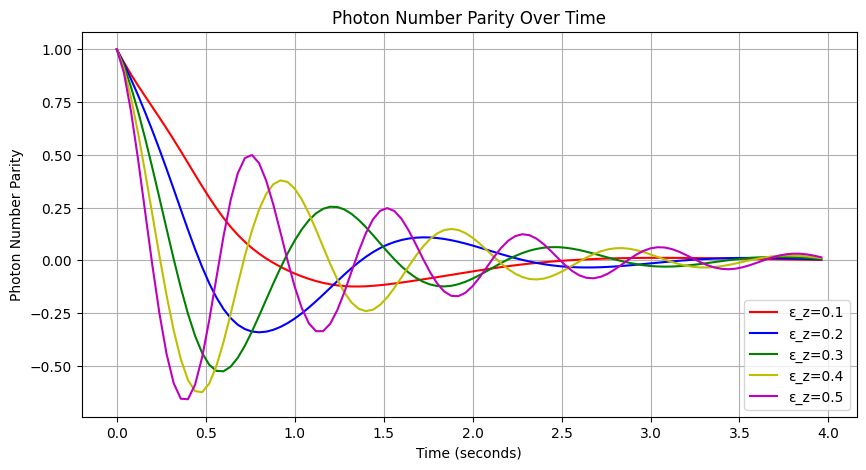

In [97]:
pars_n = [z_flip(epsilon_z, 0.1) for epsilon_z in np.arange(0.1,0.6,0.1)]

# x axis is time with 4/100 second intervals
# y axis is photon number parity (par_n) at each point

# Define the time axis with 4/100 second intervals
time = np.arange(len(pars_n[0])) * (4 / 100)  # 4/100 seconds per interval
# Creating the plot with proper labels
plt.figure(figsize=(10, 5))
for i in range(0, len(pars_n)):
    plt.plot(time, pars_n[i], marker='', linestyle='-', color=['r','b','g','y','m'][i])
plt.legend(["ε_z="+str(round(i, 1)) for i in np.arange(0.1,0.6,0.1)], loc="lower right")
plt.title("Photon Number Parity Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Photon Number Parity")
plt.grid(True)

# Show the plot
plt.show()

We can see that as $\epsilon_z$ increases, the oscillations of the photon number parity get more frequent; in other words, the rotation is performed faster.

We can similarly fix $\epsilon_z$ to be 0.25 and observe the photon number parity for different values of $\kappa_a$ between 0.1 and 2:

|██████████| 100.0% ◆ elapsed 461.45ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 524.10ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 530.22ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 457.75ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 489.77ms ◆ remaining 0.00ms  
/Users/adamgodel/2025-Alice-and-Bob/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/adamgodel/2025-Alice-and-Bob/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


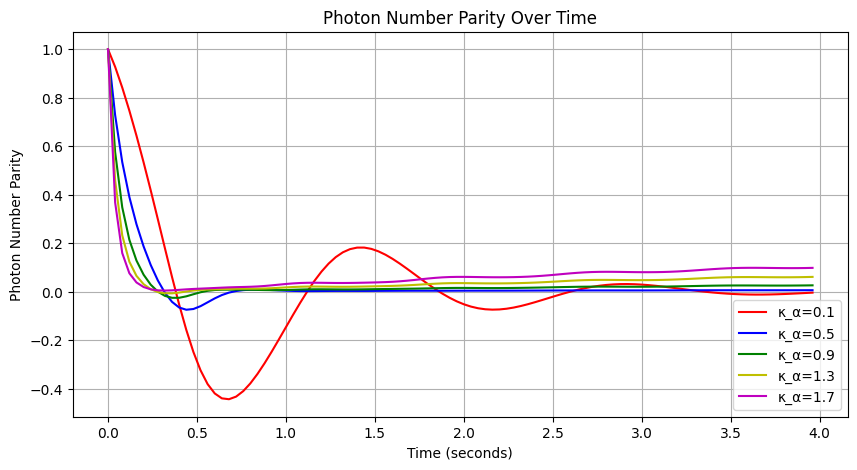

In [104]:
pars_n = [z_flip(0.25, kappa_a) for kappa_a in np.arange(0.1,2,0.4)]

# x axis is time with 4/100 second intervals
# y axis is photon number parity (par_n) at each point

# Define the time axis with 4/100 second intervals
time = np.arange(len(pars_n[0])) * (4 / 100)  # 4/100 seconds per interval
# Creating the plot with proper labels
plt.figure(figsize=(10, 5))
for i in range(0, len(pars_n)):
    plt.plot(time, pars_n[i], marker='', linestyle='-', color=['r','b','g','y','m'][i])
plt.legend(["κ_α="+str(round(i, 1)) for i in np.arange(0.1,2.1,0.4)], loc="lower right")
plt.title("Photon Number Parity Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Photon Number Parity")
plt.grid(True)

# Show the plot
plt.show()

We can see that as $\kappa_\alpha$ increases, the photon number parity drops more sharply and stabilizes at 0.
### Task 1.4: Optimal control for state-preparation
For this task, we let $\epsilon_d$ depend on time instead of being constant, and aim to find the optimal function of time of $\epsilon_d(t)$ to inflate a cat from the vacuum to a target value of $\alpha^2 = 4$ in exactly 3 seconds. 

To approach this, we create $\hat{a}$ and $\hat{b}$ and initialize $|\psi\rangle$ to the vacuum as before, but then create an optimization algorithm where we compute the loss for $\epsilon_d$ and $\alpha^2$. We recall that $\alpha^2 = -\epsilon_d / g_2^{*}$, and so by optimizing $\epsilon_d$, we can concurrently optimize $\alpha^2$. We run 300 epochs with 30 bins dividing up 3 seconds. The algorithm took us about 16 minutes to run:

In [268]:
(na, nb) = (20, 5)
a, b = dq.destroy(na, nb)
adag, bdag = a.dag(), b.dag()
psi0 = dq.fock((na, nb), (0, 0))

kappa_b = 10
g2 = 1.0

ntpulse = 101
nepochs = 300
learning_rate = 0.2
bins = 30

def compute_epsilon_d(amps):
    H2ph = g2 * (adag @ adag) @ b + jnp.conj(g2) * (a @ a) @ bdag
    Hd = dq.pwc(np.linspace(0, 3, bins), amps, a+adag)
    H = H2ph + Hd

    result = dq.mesolve(H, [jnp.sqrt(kappa_b) * b], psi0, tsave)
    rho = dq.ptrace(result.states, 0)

    return jnp.absolute(dq.expect(dq.number(na), rho[-1]))

@jax.jit
def compute_epsilon_d_loss(amps, weight=1.0):
    return weight * (1 - compute_epsilon_d(amps))

@jax.jit
def compute_alpha_sq_loss(amps, weight=1.0):
    return weight * (4.0 - compute_epsilon_d(amps)/jnp.conj(g2))

optimizer = optax.adam(learning_rate)
amps = jnp.array([-4+0j]*(bins-1))
opt_state = optimizer.init(amps)
losses = []
for _ in range(nepochs):
    epsilon_d_loss, epsilon_d_grad = jax.value_and_grad(compute_epsilon_d_loss)(amps)
    alpha_sq_loss, alpha_sq_grad = jax.value_and_grad(compute_alpha_sq_loss)(amps)
    grads = epsilon_d_grad + alpha_sq_grad

    updates, opt_state = optimizer.update(grads.conj(), opt_state)
    amps = optax.apply_updates(amps, updates)

    losses.append([epsilon_d_loss, alpha_sq_loss])

losses = jnp.asarray(losses)

|██████████| 100.0% ◆ elapsed 385.22ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 329.01ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 325.56ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 325.14ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 336.84ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 337.77ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 346.77ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 343.49ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 334.03ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 356.35ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 367.41ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 368.03ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 405.21ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 435.55ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 547.77ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 412.42ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 362.01ms ◆

Once the algorithm completed, we were left with the following losses over the 300 epochs:

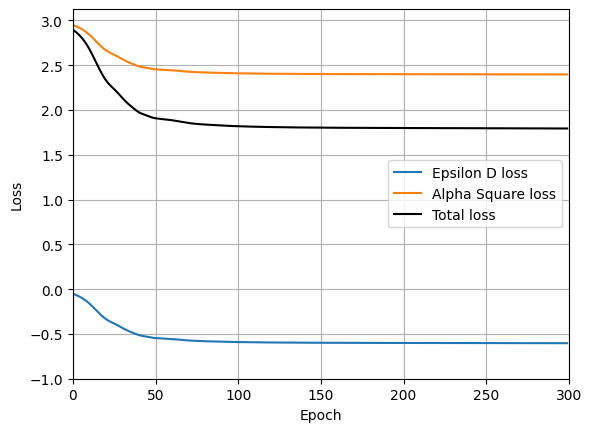

In [269]:
plt.plot(losses[:, 0], label="Epsilon D loss")
plt.plot(losses[:, 1], label="Alpha Square loss")
plt.plot(losses[:, 0] + losses[:, 1], c='k', label="Total loss")
plt.ylim(-1)
plt.xlim(0, nepochs)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

As expected, the expected value of number of photons over time reaches 4 precisely at $T=3$, meaning our optimization algorithm works as intended!

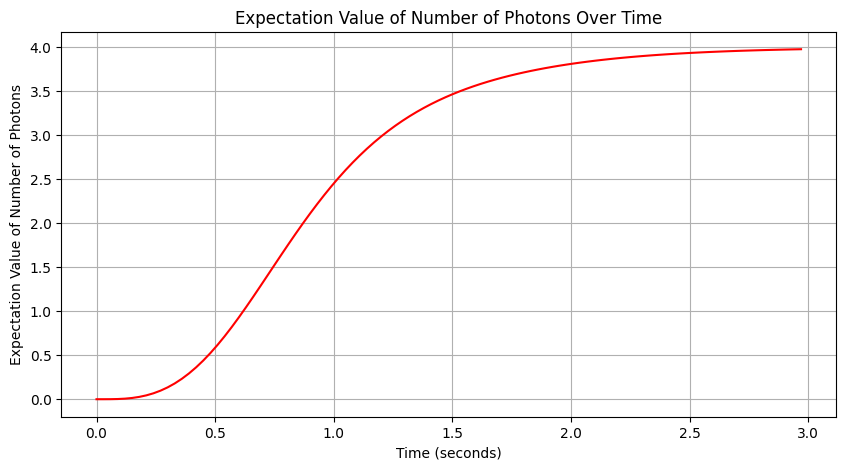

In [270]:
exp_n = dq.expect(dq.number(na), rho)

# x axis is time with 3/100 second intervals
# y axis is going expectation value of number of photons (exp_n) at each point

# Define the time axis with 3/100 second intervals
time = np.arange(len(exp_n)) * (3 / 100)  # 3/100 seconds per interval
# Creating the plot with proper labels
plt.figure(figsize=(10, 5))
plt.plot(time, exp_n.real, marker='', linestyle='-', color='r')
plt.title("Expectation Value of Number of Photons Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Expectation Value of Number of Photons")
plt.grid(True)

# Show the plot
plt.show()

## Task 2: Simulate the dynamics of cat qubits at the circuit level.
This task complexifies the simulations we have been making by considering simulations of quantum systems at the circuit level. We simulate the two-photon interaction using ATS with a flux pump with the following Lindblad master equation:
$$
\frac{d\hat{\rho}}{dt} = L[\hat{\rho}] = -i[\hat{H}, \hat{\rho}] + \kappa_b D(\hat{b})[\hat{\rho}] + \kappa_a D(\hat{a}) [\hat{\rho}]
$$
At the saddle point ($\varphi_\Sigma = \pi/2 + \epsilon(t)$, $\varphi_\Delta = \pi/2$) the Hamiltonian of the system is given by
$$
\begin{align*}
\hat{H} &= \hat{H}_0 + \hat{H}_{ATS} + \hat{H}_d, \text{ with} \\
\hat{H}_0 &= \omega_{a,0} \hat{a}^\dag \hat{a} + \omega_{b,0} \hat{b}^\dag \hat{b}, \\
\hat{H}_{ATS} &= -2E_J \sin(\epsilon(t))\sin(\hat{\varphi}) + 2\Delta E_J \cos(\epsilon(t)) \cos(\hat{\varphi}), \\
\hat{H}_d &= 2\epsilon_d \cos(\omega_d t) (\hat{b} + \hat{b}^\dag)
\end{align*}
$$
where $\epsilon(t) = \epsilon_p \cos(\omega_p t)$. We will explore this model and how to simulate it effectively throughout this section.
### Task 2.1: Lab frame simulation
This task asks us to use `dynamiqs` to simulate the time evolution of this system by taking and plugging in the parameters found in [this paper](https://arxiv.org/abs/2307.06617). The following code employs a similar approach to Task 1.1, plugging in all of the parameters based on the Hamiltonian formulas above and simulate from $T=0$ and $T=4$. Note that this function takes a long time to run; we were able to run it in about 40 minutes. Additionally, note that we must perform unit conversions to ensure we are working with the same units; we chose to use MHz and μs.

In [ ]:
(na, nb) = (20, 5)
a, b = dq.destroy(na, nb)
adag, bdag = a.dag(), b.dag()
psi0 = dq.fock((na, nb), (0, 0))

omega_a0 = 5.26 * 1000
omega_b0 = 7.70 * 1000
phi_a = 0.06
phi_b = 0.29
Ej = 12.03 * 1000
delta_Ej = 0.47 * 1000
omega_d = 7.623 * 1000
omega_p = 2.891 *  1000
epsilon_d = -3.815 
epsilon_p = 0.122

phi_hat = phi_a * (a + adag) + phi_b * (b + bdag)

f0 = lambda t: omega_a0 * (adag @ a) + omega_b0 * (bdag @ b)
epsilon = lambda t: epsilon_p * jnp.cos(omega_p * t)
fATS = lambda t: (
    -2 * Ej * (epsilon(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/6 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 3)))
    + 2 * delta_Ej * (epsilon(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/2 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 2)))
)
fD = lambda t: 2 * epsilon_d * jnp.cos(omega_d * t) * (b + bdag)
H = dq.timecallable(f0) + dq.timecallable(fATS) + dq.timecallable(fD)

kappa_a = 9.3 / 1000
kappa_b = 2.6

tsave = jnp.linspace(0, 4, 100)
res = dq.mesolve(H, [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a) * a], psi0, tsave, solver = dq.solver.Tsit5(max_steps = 1000000000))
rho1 = dq.ptrace(res.states, 0)

/Users/etopkoc.24/iquhack2025/pyenv3/lib/python3.12/site-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|██████████| 100.0% ◆ elapsed 46m55s ◆ remaining 0.00ms  


We can plot the Wigner function of this state to observe it spinning and spreading out; eventually, if it were to keep going, we would see the cat states separate:

100%|██████████| 50/50 [00:01<00:00, 27.87it/s]


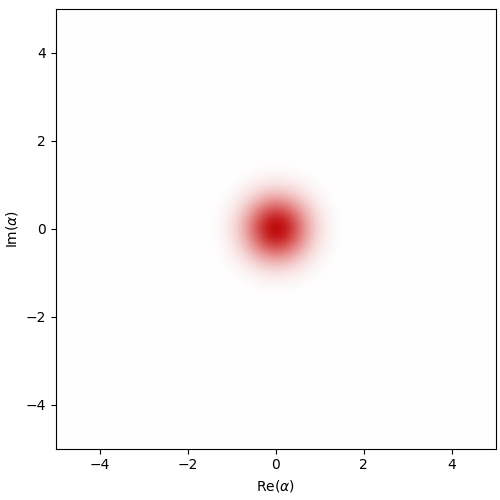

In [6]:
dq.plot.wigner_gif(rho1)

The code block below displays a mosaic view of the motion:

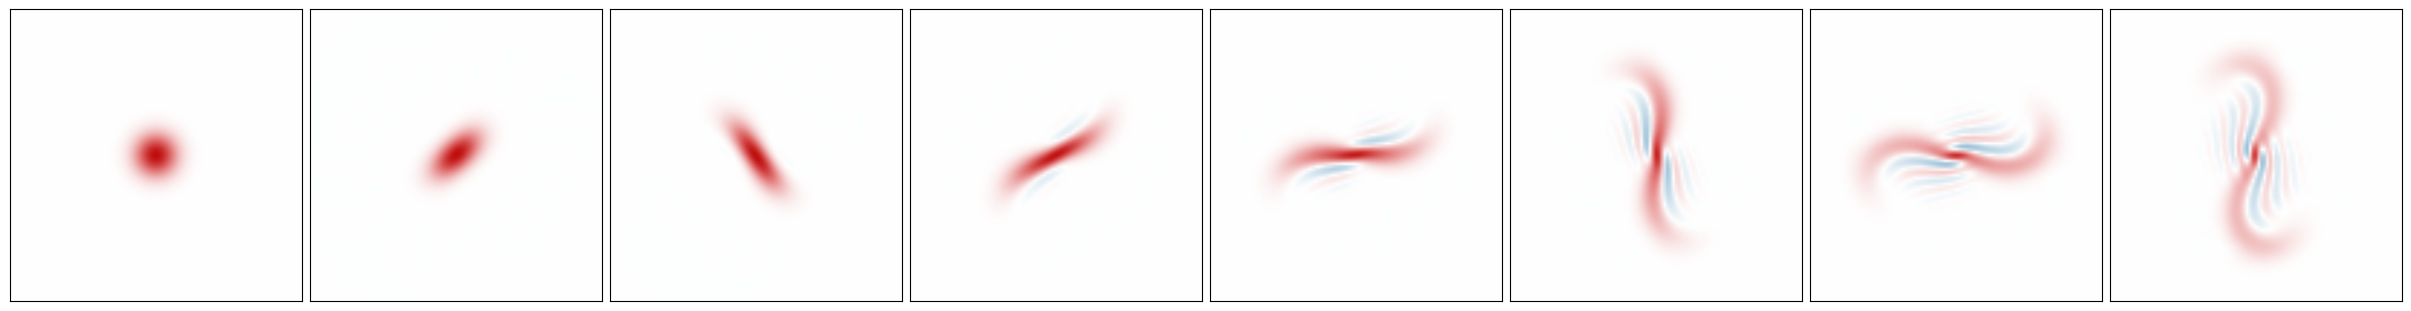

In [7]:
dq.plot.wigner_mosaic(rho1)

### Task 2.2: Rotated-displaced frame simulation
Unfortunately, while we were able to code Tasks 2.2-2.4, we weren't able to run them due to their computational intensity, even when performing certain optimizations, e.g. Taylor expansions. We had issues either accessing certain GPUs or running the notebook cells efficiently on different GPUs we tried, so we can only provide the code for these remaining sections without the Wigner functions.

Task 2.2 asks us to transform our circuit level system into a rotated-displaced frame. Following the hint model given last night, we computed all of the parameters and executed a recursive loop to compute the AC stark shift.

In [3]:
omega_a0 = 5.26 * 1000
omega_b0 = 7.70 * 1000
phi_a = 0.06
phi_b = 0.29
Ej = 12.03 * 1000
delta_Ej = 0.47 * 1000
omega_d = 7.623 * 1000
omega_p = 2.891 *  1000
epsilon_d = -3.815 
epsilon_p = 0.122
kappa_a = 9.3 / 1000
kappa_b = 2.6

delta_a, delta_b = (0.0,0.0)
omega_p = 2*omega_a0 - omega_b0

rec_depth = 30
for i in range(rec_depth):
    alpha_1 = 1j*Ej*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a0 - omega_p))
    alpha_2 = 1j*Ej*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a0 + omega_p))

    beta_1 = 1j*Ej*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b0 - omega_p))
    beta_2 = 1j*Ej*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b0 + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b

    delta_a = 1/3*Ej * epsilon_p * phi_a**2 * pre 
    delta_b = 1/3*Ej * epsilon_p * phi_b**2 * pre 

    omega_a = omega_a0 - 2*delta_Ej*phi_a**2 + delta_a 
    omega_b = omega_b0 - 2*delta_Ej*phi_b**2 + delta_b 
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

Similarly to the models we simulated in previous tasks, we followed the hint notebook to initialize states $\hat{a}$ and $\hat{b}$ and create $|\psi_0\rangle$ as the vacuum state. Furthermore, we initialized $\alpha_t$ and $\beta_t$ and the corresponding transformed versions of $\hat{a}$, $\hat{a}^\dag$, $\hat{b}$, and $\hat{b}^\dag$, where $\hat{a} \to \hat{a} + \alpha_t$, $\hat{a}^\dag \to \hat{a}^\dag + \alpha_t^{*}$, and similarly for $\hat{b}$ and $\hat{b}^\dag$.

We then wrote out $H_0$, $H_{rot}$, and $H_{disp}$, with the latter two Hamiltonians encoding the rotation and the displacement separately and respectively. For the sine and cosine terms necessary for $H_{ATS}$, we opted to use the Taylor series expansion up to the third order for sine and second order for cosine to make our function more efficient; unfortunately, it still wasn't enough to run it efficiently on a CPU or the limited GPUs we had access to.

Calculating $H_D$ as before, we ultimately find that
$$
H = H_0 + H_{ATS} + H_D + H_{rot} + H_{disp}.
$$

In [ ]:
(na, nb) = (30, 7)
a, b = dq.destroy(na, nb)
adag, bdag = a.dag(), b.dag()
identity = dq.tensor(dq.eye(na), dq.eye(nb))
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)
psi0 = dq.fock((na, nb), (0, 0))

def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

def hamiltonian_rotating_displaced(t):
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)

    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))

    a_f = op_rot_displaced(t, a, omega_d, alpha_t)
    adag_f = op_rot_displaced(t, adag, omega_d, alpha_t)
    b_f = op_rot_displaced(t, b, omega_d, beta_t)
    bdag_f = op_rot_displaced(t, bdag, omega_d, beta_t)
    omega_rot_a = omega_a0 + alpha_t
    omega_rot_b = omega_b0 + beta_t

    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)
    h_0 = omega_a0 * adag_f @ a_f + omega_b0 * bdag_f @ b_f
    h_rot = - omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))
        
    sinterm = eps_ats(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/6 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 3)) # jnp.sin(eps_ats(t)) * dq.sinm(phi_f)
    costerm = eps_ats(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/2 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 2)) # jnp.cos(eps_ats(t)) * dq.cosm(phi_f)
    h_ats = - 2*Ej*sinterm +  2*delta_Ej*costerm 
    
    h_buffer_drive = jnp.conj(epsilon_d)*jnp.exp(1j*omega_d*t)*b_f \
        + epsilon_d * jnp.exp(-1j*omega_d*t) * bdag_f
    
    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis

H = dq.timecallable(hamiltonian_rotating_displaced)

tsave = jnp.linspace(0, 1, 10)
res = dq.mesolve(H, [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a) * a], psi0, tsave, solver = dq.solver.Tsit5(max_steps = 1000000000))
rho2 = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho2)

### Task 2.3: Comparison with effective model
Unfortunately, since we were unable to execute Task 2.2 due to computational constraints, we couldn't run the fidelity comparison asked in this task.

In [ ]:
dq.fidelity(rho1, rho2)

### Task 2.4: Optimal control
For this task, we aimed to spin off our optimization algorithm from Task 1.4 to work on full circuit Hamiltonians with each element dependent on time. 

In [ ]:
(na, nb) = (5, 3)
a, b = dq.destroy(na, nb)
adag, bdag = a.dag(), b.dag()
psi0 = dq.fock((na, nb), (0, 0))

omega_a0 = 5.26 * 1000
omega_b0 = 7.70 * 1000
phi_a = 0.06
phi_b = 0.29
Ej = 12.03 * 1000
delta_Ej = 0.47 * 1000
omega_d = 7.623 * 1000
omega_p = 2.891 *  1000
epsilon_d = -3.815 
epsilon_p = 0.122
kappa_a = 9.3 / 1000
kappa_b = 2.6
tsave = jnp.linspace(0, 3, 10)
phi_hat = phi_a * (a + adag) + phi_b * (b + bdag)
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)

bins = len(tsave) - 1 
amps = jnp.array([-4 + 0j] * (bins-1)) 

def compute_hamiltonian(amps, t_idx):
    f0 = lambda t: omega_a0 * (adag @ a) + omega_b0 * (bdag @ b)
    fATS = lambda t: (
        -2 * Ej * (eps_ats(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/6 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 3)))
        + 2 * delta_Ej * (eps_ats(t) * (phi_a * (a + adag) - phi_b * (b + bdag) - 1/2 * dq.powm(phi_a * (a + adag) + phi_b * (b + bdag), 2)))
    )   
    HD = dq.pwc(np.linspace(0, 3, bins), amps, a+adag)
    return dq.timecallable(f0) + dq.timecallable(fATS) + HD

@jax.jit
def compute_epsilon_d_loss(amps, weight=1.0):
    H = compute_hamiltonian(amps, tsave)
    result = dq.mesolve(H, [jnp.sqrt(kappa_b) * b], psi0, tsave, solver = dq.solver.Tsit5(max_steps = 1000000000))
    rho = dq.ptrace(result.states, 0)
    exp_n = jnp.real(dq.expect(dq.number(na), rho[-1]))
    return weight * (1 - exp_n) 

@jax.jit
def compute_alpha_sq_loss(amps, weight=1.0):
    H = compute_hamiltonian(amps, tsave)
    result = dq.mesolve(H, [jnp.sqrt(kappa_b) * b], psi0, tsave, solver = dq.solver.Tsit5(max_steps = 1000000000))
    rho = dq.ptrace(result.states, 0)
    exp_n = jnp.real(dq.expect(dq.number(na), rho[-1])) 
    return weight * (4.0 - exp_n) ** 2 

learning_rate = 0.2
nepochs = 50
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(amps)

losses = []
for epoch in range(nepochs):
    epsilon_d_loss, epsilon_d_grad = jax.value_and_grad(compute_epsilon_d_loss)(amps)
    alpha_sq_loss, alpha_sq_grad = jax.value_and_grad(compute_alpha_sq_loss)(amps)
    
    total_grad = epsilon_d_grad + alpha_sq_grad
    updates, opt_state = optimizer.update(total_grad.conj(), opt_state)
    amps = optax.apply_updates(amps, updates)

    losses.append([epsilon_d_loss, alpha_sq_loss])

losses = jnp.asarray(losses)

plt.figure(figsize=(10, 5))
plt.plot(losses[:, 0], label="Epsilon D Loss")
plt.plot(losses[:, 1], label="Alpha Square Loss")
plt.plot(losses[:, 0] + losses[:, 1], label="Total Loss", color='k')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Loss Evolution Over Training")
plt.show()


H_final = compute_hamiltonian(amps, tsave)
result = dq.mesolve(H_final, [jnp.sqrt(kappa_b) * b], psi0, tsave)
rho_final = dq.ptrace(result.states, 0)


dq.plot.wigner_gif(rho_final)